# Notebook demo of using vqe module to solve a QUBO

In [1]:
import sys
sys.path.append('../')

from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
import aquapointer.digital.qubo_utils as qutils
from aquapointer.digital.vqe import VQE

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz
from qiskit.primitives import Sampler
from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
sampler = Sampler(options={"shots": int(1e4)})

In [2]:
# LoadData does all the file loading
ld = LoadData()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld)

In [3]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

# QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

from qiskit.circuit.library import TwoLocal
# TwoLocal ansatz circuit
twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
qubo

array([[-0.01074377,  0.04727714,  0.04727714,  0.04727714],
       [ 0.04727714, -0.00892812,  0.03218907,  0.04727714],
       [ 0.04727714,  0.03218907, -0.00865155,  0.04727714],
       [ 0.04727714,  0.04727714,  0.04727714, -0.00969204]])

In [4]:
# classical brute-force solution
sol, ref_value = q.find_optimum(qubo=qubo)
sol, ref_value

('1000', -0.010743767178636635)

In [5]:
def top_average_energy(vqe_object: VQE, alpha: float, maxiter: int, fraction: float, verbose=False):

    res = vqe_object.run(alpha=alpha, maxiter=maxiter, method='COBYLA')
    nfev = res.nfev

    # Assign solution parameters to ansatz
    qc = vqe_object.ansatz.assign_parameters(vqe_object.params)
    # Add measurements to our circuit
    qc.measure_all()
    # Sample ansatz at optimal parameters
    samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
    samp_dist_binary = samp_dist.binary_probabilities()

    correct_dist = {}
    for key in samp_dist_binary.keys():
        reverse_key = key[::-1]
        keynot = [(int(b)+1)%2 for b in reverse_key]
        correct_dist[''.join(map(str, keynot))] = samp_dist_binary[key]

    prob_energy = []
    bitstrings = []
    for key in correct_dist.keys():
        key_np = np.fromiter(map(int, key), dtype=int)
        prob_energy.append([correct_dist[key], qutils.ising_energy(key_np, qubo)])
        bitstrings.append(key)

    bitstrings = np.array(bitstrings)
    prob_energy = np.array(prob_energy)

    sorted_indices = np.argsort(prob_energy[:, 1])
    sorted_keys = bitstrings[sorted_indices]
    sorted_values = prob_energy[:, 1][sorted_indices]

    opt_energy = sorted_values[0]
    opt_b = sorted_keys[0]
    
    #pick top 10% of lowest observed energies and compute probability mass on them
    n = int(len(prob_energy)*fraction)
    if verbose:
        if n<=1:
            print(prob_energy)

    total_mass = 0.0
    top_avg_energy = 0.0
    for i in range(n):
        total_mass += correct_dist[sorted_keys[i]]
        top_avg_energy += sorted_values[i]*correct_dist[sorted_keys[i]]
        if verbose:
            print(sorted_values[i], correct_dist[sorted_keys[i]])
    top_avg_energy = top_avg_energy / total_mass
    return round(top_avg_energy, 5), round(total_mass, 3), nfev, (opt_b, opt_energy)  

def probability_opt_sol(vqe_object: VQE, alpha: float, maxiter: int, verbose=False):

    res = vqe_object.run(alpha=alpha, maxiter=maxiter, method='COBYLA')
    nfev = res.nfev

    # Assign solution parameters to ansatz
    qc = vqe_object.ansatz.assign_parameters(vqe_object.params)
    # Add measurements to our circuit
    qc.measure_all()
    # Sample ansatz at optimal parameters
    samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
    samp_dist_binary = samp_dist.binary_probabilities()

    correct_dist = {}
    for key in samp_dist_binary.keys():
        reverse_key = key[::-1]
        keynot = [(int(b)+1)%2 for b in reverse_key]
        correct_dist[''.join(map(str, keynot))] = samp_dist_binary[key]

    prob_energy = []
    bitstrings = []
    for key in correct_dist.keys():
        key_np = np.fromiter(map(int, key), dtype=int)
        prob_energy.append([correct_dist[key], qutils.ising_energy(key_np, qubo)])
        bitstrings.append(key)

    bitstrings = np.array(bitstrings)
    prob_energy = np.array(prob_energy)

    sorted_indices = np.argsort(prob_energy[:, 1])
    sorted_keys = bitstrings[sorted_indices]
    sorted_probs = prob_energy[:, 0][sorted_indices]
    sorted_values = prob_energy[:, 1][sorted_indices]

    if verbose:
        print(prob_energy)

    opt_energy = sorted_values[0]
    opt_b = sorted_keys[0]
    opt_prob = sorted_probs[0]

    return opt_b, opt_energy, opt_prob


In [6]:
# run the optimization for a given vqe_object and a list of confidence intervals
def run_optimization(vqe_object, alphas, maxiter):
    nfevs = [] #this is for book keeping the number of function evaluations    
    opt_energy = np.inf

    for alpha in alphas:
        top_avg_energy, total_mass, nfev, opt = top_average_energy(vqe_object, alpha, maxiter, 0.2, verbose=False)
        nfevs.append(nfev)
        if opt_energy>opt[1]:
            opt_energy = opt[1]
            res = opt
            print(opt)
        print(f"{alpha}, {top_avg_energy}, {total_mass}")
    return nfevs, res

# run the optimization for a given vqe_object and a list of confidence intervals
def run_optimization_prob_opt_sol(vqe_object, alphas, maxiter, verbose=False):
    for alpha in alphas:
        opt_b, opt_energy, opt_prob = probability_opt_sol(vqe_object, alpha, maxiter)
        if verbose:
            print(f"{alpha}, {opt_energy}, {opt_prob}")
    return opt_b, opt_energy, opt_prob

#helper function to get number of basis gates used in ansatz
def total_gates(ansatz):
    basis_gates=['u1', 'u2', 'u3', 'cx']

    ansatz_transpiled = transpile(ansatz, backend, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
    gates = ansatz_transpiled.count_ops()
    depth = ansatz_transpiled.depth()
    num_params = ansatz.num_parameters

    total_gates = 0
    for gate in basis_gates:
        total_gates += gates.get(gate, 0)
    return total_gates, depth, num_params

In [7]:
qaoa_ansatz.num_parameters, twolocal_ansatz.num_parameters

(2, 8)

In [8]:
transpiles = transpile(qaoa_ansatz, backend, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
transpiles.count_ops()

OrderedDict([('cx', 24), ('u1', 16), ('u2', 4), ('u3', 4)])

In [9]:
# EXAMPLE: QAQA

alphas = [1.0, 0.75, 0.5, 0.25, 0.1]
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = beta+gamma
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

nfevs_qaoa = run_optimization(vqe_qaoa, alphas, maxiter=20)

('1000', -0.010743767178636635)
1.0, -0.00978, 0.191
0.75, -0.00977, 0.247
0.5, -0.00979, 0.305
0.25, -0.0098, 0.364
0.1, -0.00976, 0.357


In [10]:
#EXAMPLE: linear entanglement ansatz

vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)
alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

nfevs_linear = run_optimization(vqe_linear, alphas, maxiter=60)

('0000', 0.0)
1.0, 0.0, 0.237
('1000', -0.010743767178636635)
0.75, -0.01058, 0.535
0.5, -0.01072, 0.661
0.25, -0.01072, 0.664
0.1, -0.01072, 0.661


In [11]:
# # now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
# alphas = [1.0, 0.66, 0.33]
# nfevs_qaoa_slices = []
# nfevs_linear_slices = []

# res_qaoa_slices = []
# res_linear_slices = []

# for qubo, ising_ham in q.qubo_hamiltonian_pairs:
    
#     num_qubits = len(qubo)
#     qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
#     beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
#     gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
#     params = beta+gamma
#     vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

#     #using linear entanglement ansatz
#     # TwoLocal ansatz circuit
#     twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
#     vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)

#     # compute number of gates to specify maxiter for the different ansatzes
#     # to keep it fair, we want number_of_gates * maxiter to be the same for both instances
#     resources_qaoa, resources_twolocal = total_gates(qaoa_ansatz), total_gates(twolocal_ansatz)
#     maxiter_qaoa = 10
#     maxiter_linear = int(maxiter_qaoa * (resources_qaoa[1]/resources_twolocal[1]) * (resources_qaoa[2]/resources_twolocal[2]))

#     print(maxiter_qaoa, maxiter_linear)

#     print('qaoa')
#     nfevs_qaoa, res_qaoa = run_optimization(vqe_qaoa, alphas, maxiter=maxiter_qaoa)
#     nfevs_qaoa_slices.append(nfevs_qaoa)
#     res_qaoa_slices.append(res_qaoa)

#     print('linear')
#     nfevs_linear, res_linear = run_optimization(vqe_linear, alphas, maxiter=maxiter_linear)
#     nfevs_linear_slices.append(nfevs_linear)
#     res_linear_slices.append(res_linear)


In [12]:
# res_qaoa_slices

In [13]:
# res_linear_slices

In [14]:
# now apply the function that maps these bitstrings to water molecule position

# Resource estimation/performance

In [15]:
# depth * number_of_params * maxiter is the same for both approaches, this makes a fair comparison in performance

In [16]:
# EXAMPLE: QAQA

alphas = [1.0, 0.75, 0.5, 0.25, 0.1]
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = beta+gamma
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

probability_opt_sol(vqe_object=vqe_qaoa, alpha=0.9, maxiter=10)

('1000', -0.010743767178636635, 0.0978)

In [17]:
# let us first list the optimal solutions for the qubo problems using the classical brute force approach
optimal_solutions = []

for qubo in q.qubo_hamiltonian_pairs:
    # classical brute-force solution
    solution = q.find_optimum(qubo=qubo[0])
    optimal_solutions.append(solution)

optimal_solutions

[('1000', -0.010743767178636635),
 ('010000001', -0.05676551209085727),
 ('10001000000001', -0.07861404665042948),
 ('10000000100100', -0.07111143020268126),
 ('0000010100000', -0.05195638819992217),
 ('00010000', -0.02404680978135616)]

In [18]:
import time
# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [1.0, 0.5]
number_of_iterations = list(range(10, 50, 4))


res_qaoa_slices = []
res_linear_slices = []

i = 0

num_mc = 5

for qubo, ising_ham in q.qubo_hamiltonian_pairs:
    num_qubits = len(qubo)
    opt_sol = optimal_solutions[i]
    res_qaoa = []
    res_linear = []
    print(f"slice {i}")
    i+=1
    
    # define the ansatzes
    qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
    beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
    gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
    params = beta+gamma

    # TwoLocal ansatz circuit
    twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

    resources_qaoa, resources_twolocal = total_gates(qaoa_ansatz), total_gates(twolocal_ansatz)

    iter_factor = int((resources_qaoa[1]/resources_twolocal[1]) * (resources_qaoa[2]/resources_twolocal[2]))
    
    for maxiter in number_of_iterations:
        prob_qaoa = []
        prob_linear = []
        
        # to keep it fair, we want depth * number_of_params * maxiter to be the same for both instances
        maxiter_qaoa = maxiter
        maxiter_linear = maxiter_qaoa * iter_factor

        #time the last iteration
        if maxiter == number_of_iterations[-1]:
            start = time.time()
        for _ in range(num_mc):
            vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)
            # print('qaoa')
            res = run_optimization_prob_opt_sol(vqe_qaoa, alphas, maxiter=maxiter_qaoa)
            if opt_sol[0] == res[0]:
                prob_qaoa.append(res[2])
            else:
                prob_qaoa.append(0.0)

        if maxiter == number_of_iterations[-1]:
            end = time.time()
            print(f'QAQA time elapsed: {end-start} ')
            
        #time the last iteration
        if maxiter == number_of_iterations[-1]:
            start = time.time()
        for _ in range(num_mc):
            vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)
            # print('linear')
            res = run_optimization_prob_opt_sol(vqe_linear, alphas, maxiter=maxiter_linear)
            if opt_sol[0] == res[0]:
                prob_linear.append(res[2])
            else:
                prob_linear.append(0.0)
        if maxiter == number_of_iterations[-1]:
            end = time.time()
            print(f'twolocal time elapsed: {end-start} ')
        res_qaoa.append(prob_qaoa)        
        res_linear.append(prob_linear)
    
    res_qaoa_slices.append(res_qaoa)
    res_linear_slices.append(res_linear)

slice 0
QAQA time elapsed: 1.9205098152160645 
twolocal time elapsed: 0.8133606910705566 
slice 1
QAQA time elapsed: 12.12155795097351 
twolocal time elapsed: 6.642838954925537 
slice 2
QAQA time elapsed: 173.8450801372528 
twolocal time elapsed: 248.9436550140381 
slice 3
QAQA time elapsed: 204.10208201408386 
twolocal time elapsed: 243.63016176223755 
slice 4
QAQA time elapsed: 56.5631742477417 
twolocal time elapsed: 77.53012609481812 
slice 5
QAQA time elapsed: 6.094420909881592 
twolocal time elapsed: 4.460008859634399 


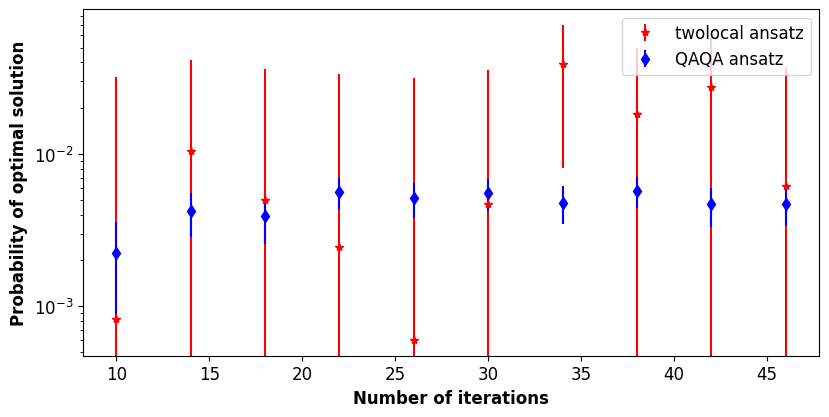

In [83]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

slice = 4

errorbar_linear = np.std(np.array(res_linear_slices[slice]))
errorbar_qaoa = np.std(np.array(res_qaoa_slices[slice]))

# plt.plot(number_of_iterations, np.mean(np.array(res_linear_slices[slice]), axis=1), '*r', label='twolocal ansatz')
plt.errorbar(number_of_iterations, np.mean(np.array(res_linear_slices[slice]), axis=1), yerr=errorbar_linear, fmt='*r', label='twolocal ansatz')
plt.errorbar(number_of_iterations, np.mean(np.array(res_qaoa_slices[slice]), axis=1), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Probability of optimal solution')
plt.show()

In [84]:
#saving the files in a pickle file so we can analyze it without rerunning it later.

import pickle
with open('le_10-50-4_5.pkl', 'wb') as f:
    pickle.dump(res_linear_slices, f)

with open('qaoa_10-50-4_5.pkl', 'wb') as f:
    pickle.dump(res_qaoa_slices, f)